## 1. Setup and Import libraries

In [1]:
# django path
mysite_path = "C:\\Data\\UCL\\@MSc Project\\DB\\mysite\\"

In [2]:
# standard packages
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import django
from set_django_db import set_django_db
from asgiref.sync import sync_to_async

from IPython.core.display import HTML

%matplotlib inline

In [3]:
# set django models
set_django_db(mysite_path)
from tables_daniel.models import Company, Review

# specifically for Jupyter notebooks
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [4]:
# set pandas display
pd.set_option('display.max_rows', 100)

In [5]:
# center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical_align: middle;
}
</style>
""")

## 2. Filter companies (+reviews) listed on FTSE 100

### 2.1 Load the data

#### 2.1.1 Companies

In [6]:
companies = pd.DataFrame(
    list(
        Company
        .objects
        .values('id', 'Company', 'Country', 'Sector', 'Industry', 'NoEmployees', 'Revenue')
        .all()
        .filter(ListedOn='FTSE 100')
    )
)

In [7]:
companies['TotalReviews'] = 0

def sumReviews(row):
    try:
        return len(
            list(
                Review
                .objects
                .all()
                .filter(Company=companies.loc[row, 'id'])
            )
        )
    except:
        return 0


for row in range(companies.shape[0]):
    companies.loc[row, 'TotalReviews'] = sumReviews(row)

In [8]:
companies

,id,Company,Country,Sector,Industry,NoEmployees,Revenue,TotalReviews
0,551,3i,None,None,None,0,331000.0,10
1,552,Admiral Group,Ty Admiral,Financial Services,Insurance—Property & Casualty,11246,1360300.0,110
2,553,Anglo American plc,London SW1Y 5AN,Basic Materials,Other Industrial Metals & Mining,63000,29870000.0,70
3,554,Antofagasta,Cleveland House,Basic Materials,Copper,6532,4964500.0,6
4,555,Ashtead Group,London EC2V 6DT,Industrials,Rental & Leasing Services,19284,5053600.0,0
5,556,Associated British Foods,Weston Centre,Consumer Defensive,Packaged Foods,138000,15938000.0,20
6,557,AstraZeneca,Cambridge Biomedical Campus,Healthcare,Drug Manufacturers—General,70600,25247000.0,730
7,558,Auto Trader Group,4th Floor,Communication Services,Internet Content & Information,853,368900.0,30
8,559,Avast,Pikrtova 1737/1A,Technology,Software—Infrastructure,1792,871100.0,50
9,560,Aveva,High Cross,Technology,Software—Application,4600,833800.0,41


#### 2.1.2 Reviews

In [9]:
companies_id = list(companies.id)

In [13]:
%time
reviews = list(
    Review
    .objects
    .values('Company_id', 'ReviewTitle', 'Rating', 'Pros', 'Cons', 'Year', 'Month', 'Day',
            'JobTitle', 'EmployeeRelationship')
    .all()
    .filter(Company_id = company_id) for company_id in companies_id
)

Wall time: 0 ns


In [14]:
%time
reviews_df = pd.DataFrame(
    sum([list(reviews_i) for reviews_i in reviews],[])
)

Wall time: 0 ns


In [12]:
reviews_df.head()

,Company_id,ReviewTitle,Rating,Pros,Cons,Year,Month,Day,JobTitle,EmployeeRelationship
0,551,Good culture,5.0,people good to work with,can be lacking autonomy at times,2020,6,16,Current Employee,Graduate
1,551,3i,4.0,Great place to work for,Somewhat bureaucratic and not efficient,2020,1,4,Former Employee,Anonymous Employee
2,551,Great company to work,4.0,Open cultureTruly internationalGood career opp...,Long decision process / lack the agility of sm...,2019,12,12,Current Employee,Investor
3,551,Top experience,5.0,The best professional experience I’ve had,Nothing to say. Everything was great.,2019,10,21,Former Employee,Anonymous Employee
4,551,associate,3.0,interesting deals and good people,complicated management and big deal team,2019,10,21,Former Employee,Associate


### 2.2 DF transformation

Add some useful columns

In [13]:
reviews_df = reviews_df.merge(
    companies[['id', 'Company', 'Sector']].rename(columns={'id': 'Company_id',
                                                           'Company': 'Company',
                                                           'Sector': 'Sector'                                                 
                                                }),
    on='Company_id'
)

In [14]:
reviews_df['Date'] = reviews_df.apply(lambda x: '-'.join(
    [str(x['Year']), str(x['Month']), str(x['Day'])]
    ), axis=1
)

reviews_df

,Company_id,ReviewTitle,Rating,Pros,Cons,Year,Month,Day,JobTitle,EmployeeRelationship,Company,Sector,Date
0,551,Good culture,5.0,people good to work with,can be lacking autonomy at times,2020,6,16,Current Employee,Graduate,3i,None,2020-6-16
1,551,3i,4.0,Great place to work for,Somewhat bureaucratic and not efficient,2020,1,4,Former Employee,Anonymous Employee,3i,None,2020-1-4
2,551,Great company to work,4.0,Open cultureTruly internationalGood career opp...,Long decision process / lack the agility of sm...,2019,12,12,Current Employee,Investor,3i,None,2019-12-12
3,551,Top experience,5.0,The best professional experience I’ve had,Nothing to say. Everything was great.,2019,10,21,Former Employee,Anonymous Employee,3i,None,2019-10-21
4,551,associate,3.0,interesting deals and good people,complicated management and big deal team,2019,10,21,Former Employee,Associate,3i,None,2019-10-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34502,649,Review,4.0,"Work-life balance, great if you have a young f...",Lack of structured career progression,2018,8,27,Former Employee,Anonymous Employee,WPP plc,Communication Services,2018-8-27
34503,649,Engaging Projects,4.0,"Flexibility, Responsibility, Authority to get ...",Working across agencies is fun but rarely stru...,2018,8,18,Former Employee,Senior Project Manager,WPP plc,Communication Services,2018-8-18
34504,649,Healthcare and 401k are a joke,1.0,none - 401k match is extremely low,"401k has a tiny match, why bother?Healthcare i...",2018,8,16,Current Employee,Anonymous Employee,WPP plc,Communication Services,2018-8-16
34505,649,Where hacks go to die.,1.0,Lack of talent is considered a plus.,"Impersonal, low paying, account folk rule the ...",2018,7,17,Former Employee,Anonymous Employee,WPP plc,Communication Services,2018-7-17


In [15]:
def string_to_date(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m-%d')
    except:
        return datetime.strptime('1800-1-1', '%Y-%m-%d')
    
def string_to_YM(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m')
    except:
        return datetime.strptime('1800-1-1', '%Y-%m-%d')

reviews_df['Date'] = reviews_df['Date'].apply(lambda x: string_to_date(x))

reviews_df['Year-Month'] = reviews_df.apply(lambda x: string_to_YM('-'.join([str(x['Year']), str(x['Month'])])), axis=1)

In [16]:
reviews_df

,Company_id,ReviewTitle,Rating,Pros,Cons,Year,Month,Day,JobTitle,EmployeeRelationship,Company,Sector,Date,Year-Month
0,551,Good culture,5.0,people good to work with,can be lacking autonomy at times,2020,6,16,Current Employee,Graduate,3i,None,2020-06-16,2020-06-01
1,551,3i,4.0,Great place to work for,Somewhat bureaucratic and not efficient,2020,1,4,Former Employee,Anonymous Employee,3i,None,2020-01-04,2020-01-01
2,551,Great company to work,4.0,Open cultureTruly internationalGood career opp...,Long decision process / lack the agility of sm...,2019,12,12,Current Employee,Investor,3i,None,2019-12-12,2019-12-01
3,551,Top experience,5.0,The best professional experience I’ve had,Nothing to say. Everything was great.,2019,10,21,Former Employee,Anonymous Employee,3i,None,2019-10-21,2019-10-01
4,551,associate,3.0,interesting deals and good people,complicated management and big deal team,2019,10,21,Former Employee,Associate,3i,None,2019-10-21,2019-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34502,649,Review,4.0,"Work-life balance, great if you have a young f...",Lack of structured career progression,2018,8,27,Former Employee,Anonymous Employee,WPP plc,Communication Services,2018-08-27,2018-08-01
34503,649,Engaging Projects,4.0,"Flexibility, Responsibility, Authority to get ...",Working across agencies is fun but rarely stru...,2018,8,18,Former Employee,Senior Project Manager,WPP plc,Communication Services,2018-08-18,2018-08-01
34504,649,Healthcare and 401k are a joke,1.0,none - 401k match is extremely low,"401k has a tiny match, why bother?Healthcare i...",2018,8,16,Current Employee,Anonymous Employee,WPP plc,Communication Services,2018-08-16,2018-08-01
34505,649,Where hacks go to die.,1.0,Lack of talent is considered a plus.,"Impersonal, low paying, account folk rule the ...",2018,7,17,Former Employee,Anonymous Employee,WPP plc,Communication Services,2018-07-17,2018-07-01


## 3. Company exploration

### 3.1 Companies and reviews per sector

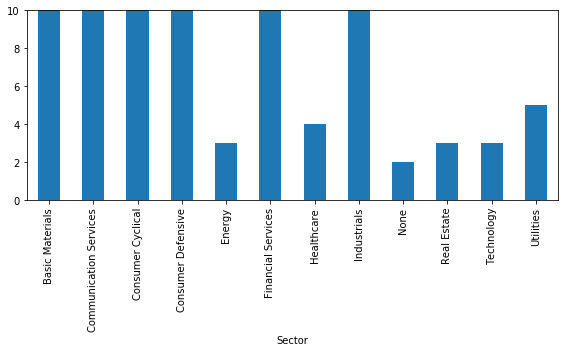

In [17]:
plt.figure(figsize=(8,5))

(companies
 .groupby('Sector')
 .count()
 .id
 .plot
 .bar()
)

plt.ylim(top = 10)

plt.tight_layout()

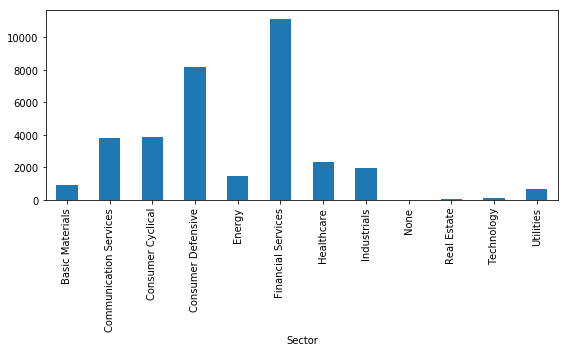

In [18]:
plt.figure(figsize=(8,5))

(reviews_df
 .groupby('Sector')
 .count()
 .Company_id
 .plot
 .bar()
)

plt.tight_layout()

In [23]:
# further analysis focusing only on the companies with at least 10 reviews in the monitored period
min_date = datetime.strptime('2018-7-1', '%Y-%m-%d')
max_date = datetime.strptime('2020-6-30', '%Y-%m-%d')

reviews_bySector = pd.DataFrame(reviews_df[(reviews_df.Date >= min_date) & (reviews_df.Date <= max_date)]
 .groupby(['Company'])
 .Rating
 .agg(['count'])
)

reviews_bySector = pd.DataFrame(reviews_bySector.to_records())

companies['newCount'] = 0

for row in range(reviews_bySector.shape[0]):
    company, count = reviews_bySector.iloc[row,]['Company'], reviews_bySector.iloc[row,]['count']
    ind = companies[companies.Company==company].index
    companies.loc[ind, 'newCount'] = count

(companies[companies.newCount>10]
 .groupby('Sector')
 .count()
 .id
)

Sector
Basic Materials            9
Communication Services    10
Consumer Cyclical         15
Consumer Defensive        11
Energy                     2
Financial Services        17
Healthcare                 4
Industrials               10
Real Estate                2
Technology                 2
Utilities                  4
Name: id, dtype: int64

### 3.2 Companies per industry

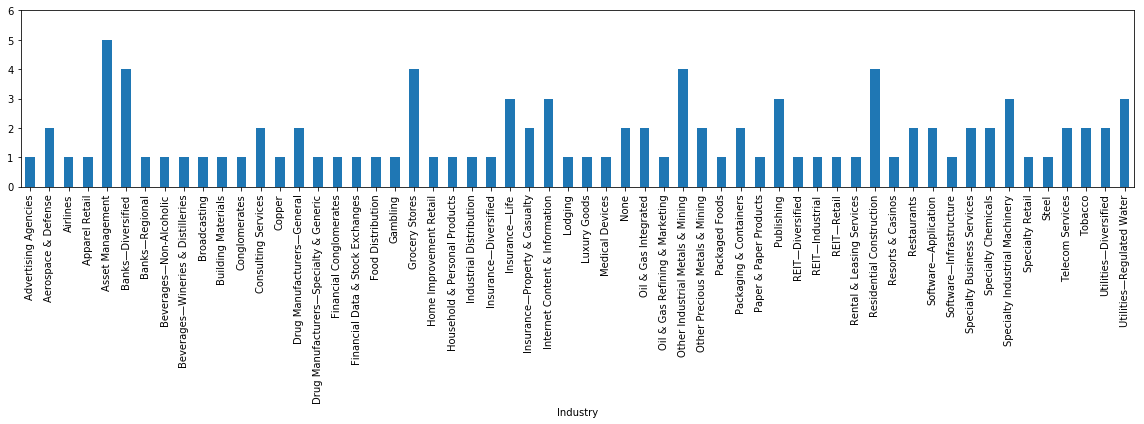

In [19]:
plt.figure(figsize=(16,6))

(companies
 .groupby('Industry')
 .count()
 .id
 .plot
 .bar()
)

plt.ylim(top = 6)

plt.tight_layout()

## 4. Review/ratings exploration

In [20]:
min_date = datetime.strptime('2018-7-1', '%Y-%m-%d')
max_date = datetime.strptime('2020-6-30', '%Y-%m-%d')

### 4.1 Mean rating - per month & sector

In [22]:
reviews_MonthSector = pd.DataFrame(reviews_df[(reviews_df.Date >= min_date) & (reviews_df.Date <= max_date)]
 .groupby(['Sector', 'Year-Month'])
 .agg(['count', 'mean'])
)

reviews_MonthSector = pd.DataFrame(
    reviews_MonthSector.to_records()
)[['Sector', 'Year-Month', "('Rating', 'mean')", "('Rating', 'count')"]]

reviews_MonthSector.columns = ['Sector', 'Year-Month', 'Rating', 'Count']

In [23]:
# add sector to the DF
sectors = reviews_MonthSector.Sector.unique()

# add 3-month rating average to the DF
reviews_MonthSector['3M_Average']=0
i=0

for sector in sectors:
    avg = reviews_MonthSector[reviews_MonthSector.Sector==sector].Rating.rolling(window=3).mean()
    
    start = i
    end = i+avg.shape[0]
    reviews_MonthSector.iloc[start:end, -1] = avg
    
    i+=avg.shape[0]

In [24]:
reviews_MonthSector

,Sector,Year-Month,Rating,Count,3M_Average
0,Basic Materials,2018-07-01,3.425532,47,NaN
1,Basic Materials,2018-08-01,3.127660,47,NaN
2,Basic Materials,2018-09-01,3.125000,32,3.226064
3,Basic Materials,2018-10-01,3.605263,38,3.285974
4,Basic Materials,2018-11-01,3.541667,24,3.423977
...,...,...,...,...,...
258,Utilities,2020-02-01,3.615385,26,3.597680
259,Utilities,2020-03-01,3.818182,22,3.652459
260,Utilities,2020-04-01,3.923077,13,3.785548
261,Utilities,2020-05-01,3.636364,22,3.792541


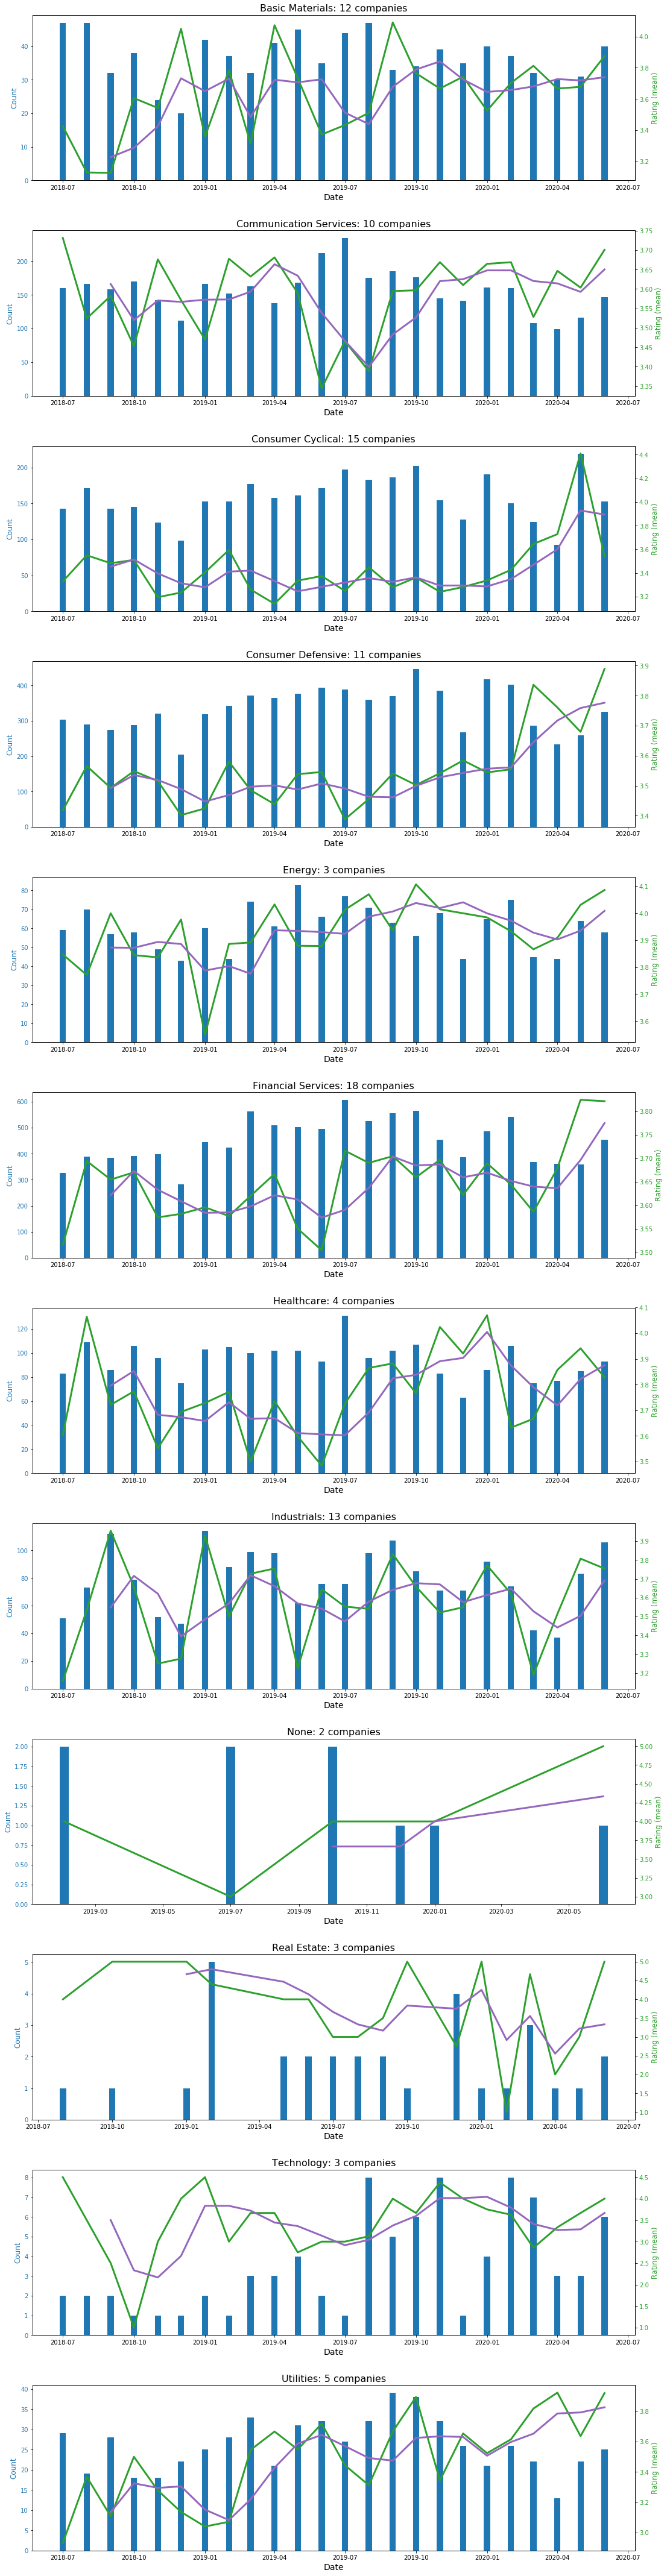

In [25]:
fig, axes = plt.subplots(len(sectors),1, figsize = (16,5*len(sectors) ))

for i, sector in enumerate(sectors):
    no_companies = companies[companies.Sector == sector].shape[0]
    
    axes[i].set_xlabel('Date', fontsize=14)
    axes[i].set_title(f'{sector}: {no_companies} companies', fontsize=16)

    color = 'tab:blue'
    axes[i].set_ylabel('Count', color=color, fontsize=12)  # we already handled the x-label with ax1
    axes[i].bar(
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Year-Month'],
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Count'],
        color=color,
        width=8
    )
    axes[i].tick_params(axis='y', labelcolor=color)

    ax2 = axes[i].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'

    ax2.set_ylabel('Rating (mean)', color=color, fontsize=12)
    ax2.plot(
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Year-Month'],
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Rating'],
        color=color,
        linewidth=3
    )
    ax2.plot(
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Year-Month'],
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['3M_Average'],
        color='tab:purple',
        linewidth=3
    )
    ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout(pad=3.0)

### 4.2 Change of mean rating - per month & sector

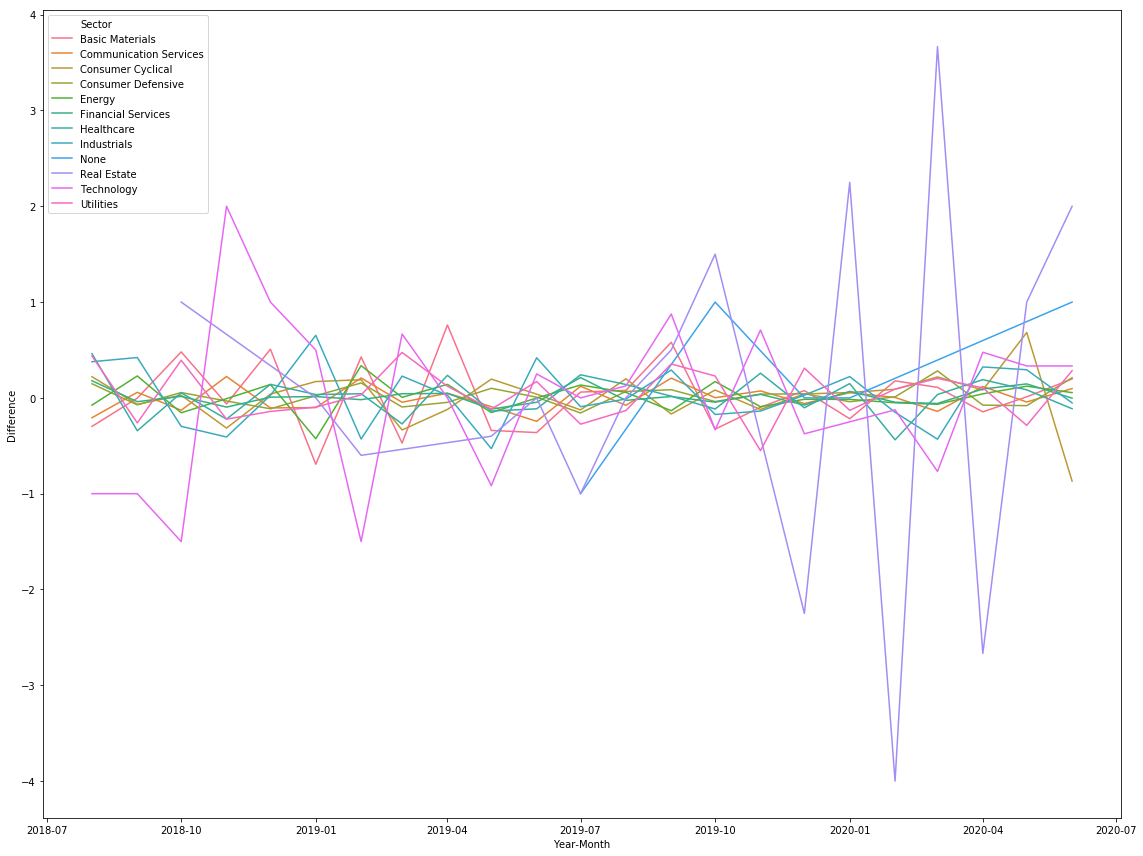

In [32]:
reviews_MonthSector['Difference'] = 0
i=0

for sector in sectors:
    diff = np.array(
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Rating'].diff()
    )
    start = i
    end = i+diff.shape[0]
    
    reviews_MonthSector.iloc[i:end, -1] = diff
    i += diff.shape[0]
    
plt.figure(figsize = (16,12))
sns.lineplot('Year-Month', 'Difference', data = reviews_MonthSector, hue = 'Sector')
plt.tight_layout()

## 5. Reviews-Employees ratio